In [2]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)

# Data Generation

In [4]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()


def generate_poisson_points_1d(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 1D region based on an intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as (xmin, xmax).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP in 1D.
    """
    xmin, xmax = region

    # Length of the region
    length = xmax - xmin
    max_intensity = kappa * length  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)  # Number of candidate samples

    # Generate candidate points
    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    candidates = torch.tensor(x_candidates, dtype=torch.float32)
    
    # Calculate intensity
    squared_norm = candidates**2
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    # Perform rejection sampling
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

## Data 1d

In [492]:
kappa = torch.tensor(1000.0)
scale = torch.tensor(0.6)

region = (-0.5, 3)

In [493]:
num_samples = 100
samples = []
for _ in range(num_samples):
    # x_t = generate_poisson_points(kappa, scale, region)
    x_t = generate_poisson_points_1d(kappa, scale, region)
    samples.append(torch.tensor(x_t).unsqueeze(-1))

In [494]:
mean_length = sum(len(sample) for sample in samples) / num_samples
mean_length

939.17

## Data 2d

In [346]:
kappa = torch.tensor(1000.0)
scale = torch.tensor(0.5)

region = ((0, 1), (0, 1))

In [327]:
num_samples = 1000
samples = []
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    samples.append(torch.tensor(x_t))

## Data Loader

In [495]:
train_ratio = 0.8
batch_size = 32
samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

X = pad_sequence(samples_torch, batch_first=True, padding_value=0)

lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

m = len(X)
train_size = int(train_ratio * m)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

C:\Users\79217\AppData\Local\Temp\ipykernel_7008\214776262.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]


In [496]:
length = int(X_train[0][0][-1].item())
x_plot = X_train[0][:length][:, 0]

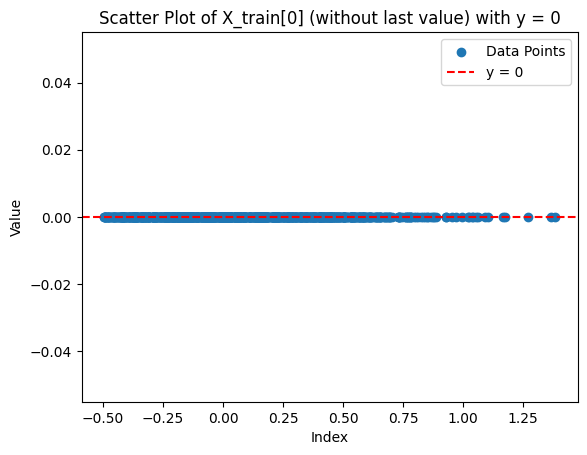

In [497]:
plt.scatter(x_plot, np.zeros_like(x_plot), label='Data Points')
plt.axhline(0, color='red', linestyle='--', label='y = 0')
plt.title('Scatter Plot of X_train[0] (without last value) with y = 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [331]:
length = int(X_train[0][0][-1].item())
x_plot = X_train[0][:length][:,:-1]

In [332]:
x = x_plot[:, 0].numpy()
y = x_plot[:, 1].numpy()
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    
intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)

fig, ax = plt.subplots(figsize=(8, 8))

if isinstance(intensity_real, torch.Tensor):
    intensity_real = intensity_real.numpy()
c = ax.contourf(
    xx, yy, intensity_real, levels=50,
    cmap='viridis', alpha=0.7,
)
ax.scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
ax.set_title('True Intensity', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c, ax=ax, label="Normalized Intensity")

plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for dimension 1 with size 1

# Neural Network Poisson Model


In [6]:
def optimize_nn(
        loader_train, nn_model, num_epochs=1000, learning_rate=1e-3, grad_clip_value=1.0, weighting=True):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        tuple: (trained model, train_losses)
    """
    def initialize_model_and_optimizer():
        model = nn_model()
        sample_input = next(iter(loader_train))[0][:,:,:-1].float() # without length dimension
        model(sample_input)  # Forward pass to initialize the layers
        optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
        return model, optimizer

    def run_epoch(loader, model, weighting, optimizer=None, total_samples=None):
        mode = model.train
        mode()

        loss_sum = 0.0
        for X_batch in loader:
            x_data = X_batch[0]
            
            optimizer.zero_grad()
            loss = model.loss(x_data, weighting=weighting)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_value)
            optimizer.step()

            loss_sum += loss.item() 

        return loss_sum / total_samples if total_samples > 0 else 0.0


    model, optimizer = initialize_model_and_optimizer()
    train_losses = []
    train_samples = len(loader_train)

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for _ in pbar:
        start_time = time.time()

        # Training phase
        avg_train_loss = run_epoch(loader_train, model, weighting, optimizer, total_samples=train_samples)
        train_losses.append(avg_train_loss)

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_train_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    return model, train_losses

In [7]:
class Poisson_NN(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=64, output_dim=1):
        super().__init__()
        torch.manual_seed(123)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = input_dim  # Initially None, determined dynamically

        # Placeholders for layers; they will be initialized once input_dim is set
        self.fc1 = None
        self.fc2 = None

    def initialize_layers(self, input_dim):
        """Initialize layers based on input_dim."""
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        if self.fc1 is None or self.fc2 is None:
            self.initialize_layers(x.shape[-1])

        x = torch.tanh(self.fc1(x))
        intensity = torch.exp(self.fc2(x))
        return intensity
    
    def compute_psi(self, x):
        x.requires_grad_(True)	
        nn_output = torch.log(torch.clamp(self.forward(x), min=1e-5))
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def gaussian_window(self, x):
        """Gaussian window function computed per dimension."""
        mean = x.mean(dim=1, keepdim=True)  # Compute mean along batch
        sigma = x.std(dim=1, keepdim=True)   # Compute std along batch
        return torch.exp(-0.5 * ((x - mean) ** 2) / (sigma ** 2)).prod(dim=-1, keepdim=True)

    def gaussian_window_derivative(self, x):
        """Derivative of the Gaussian window function computed per dimension."""
        mean = x.mean(dim=1, keepdim=True)
        sigma = x.std(dim=1, keepdim=True)
        return -(x - mean) / (sigma ** 2) * torch.exp(-0.5 * ((x - mean) ** 2) / sigma ** 2).prod(dim=-1, keepdim=True)

    def loss(self, points, weighting=True):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
        
        # Create mask to remove padding
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        psi_x = self.compute_psi(x_t) 

        if weighting:
            h = self.gaussian_window(x_t)
            grad_h = self.gaussian_window_derivative(x_t)
            weight = (psi_x * grad_h).sum(dim=-1)
        else:
            h = torch.tensor(1)
            weight = 0
            
        norm_squared = (psi_x ** 2 * h).sum(dim=-1)  # Sum across all dimensions
        
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]

        divergence = divergence * h.squeeze(-1) * mask 
        norm_squared = norm_squared * mask
        weight = weight * mask

        total_loss = 0.5 * norm_squared + divergence + weight
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension

        batch_size = points.size(0)
        total_loss = total_loss.mean() / batch_size
        
        return total_loss

In [484]:
class Poisson_NN_poly(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=32, output_dim=1, m=None, n=None):
        super().__init__()
        torch.manual_seed(123)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = input_dim  # Initially None, determined dynamically
        self.m = m  # Exponent parameter for polynomial window
        self.n = n  # Exponent parameter for polynomial window

        # Placeholders for layers; they will be initialized once input_dim is set
        self.fc1 = None
        self.fc2 = None

    def initialize_layers(self, input_dim):
        """Initialize layers based on input_dim."""
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def initialize_parameters(self, x):
        """Initialize m and n based on incoming data."""
        self.mean = x.mean()
        self.std = x.std()

        # Set m and n dynamically based on data characteristics
        self.m = 1.0 + (self.mean / (self.std + 1e-6)).abs()  # Avoid division by zero
        self.n = 1.0 + (self.std / (self.mean + 1e-6)).abs()

        print(f"Initialized parameters: m = {self.m.item():.4f}, n = {self.n.item():.4f}")

    def forward(self, x):
        if self.fc1 is None or self.fc2 is None:
            self.initialize_layers(x.shape[-1])

        if self.m is None or self.n is None:
            self.initialize_parameters(x)

        x = torch.tanh(self.fc1(x))
        intensity = torch.nn.functional.softplus(self.fc2(x))
        return intensity
    
    def compute_psi(self, x):
        x = x.float()
        x.requires_grad_()
        nn_output = torch.log(torch.clamp(self.forward(x), min=1e-8))
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def polynomial_window(self, T):
        """Polynomial window function B(x) = x^m (1-x)^n."""
        return (T ** self.m) * ((1 - T) ** self.n)

    def polynomial_window_derivative(self, T):
        """Derivative of the polynomial window function."""
        term1 = self.m * (T ** (self.m - 1)) * ((1 - T) ** self.n)
        term2 = -self.n * (T ** self.m) * ((1 - T) ** (self.n - 1))
        return term1 + term2

    def loss(self, points, weighting=True):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
        
        # Create mask to remove padding
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        psi_x = self.compute_psi(x_t) 

        if weighting:
            h = self.polynomial_window(x_t)
            grad_h = self.polynomial_window_derivative(x_t)
            weight = (psi_x * grad_h).sum(dim=-1)
        else:
            h = torch.tensor(1)
            weight = 0
            
        norm_squared = (psi_x ** 2 * h).sum(dim=-1)  # Sum across all dimensions
        
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]

        divergence = divergence * h.squeeze(-1) * mask 
        norm_squared = norm_squared * mask
        weight = weight * mask

        total_loss = 0.5 * norm_squared + divergence + weight
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension

        batch_size = points.size(0)
        total_loss = total_loss.mean() / batch_size
        
        return total_loss

In [500]:
epochs = 100
learning_rate = 1e-5

In [507]:
model, train_losses = optimize_nn(
        loader_train, Poisson_NN, num_epochs=epochs, learning_rate=learning_rate, weighting=False,
    )

Training: 100%|██████████| 100/100 [00:35<00:00,  2.82epoch/s, Train Loss=-0.8643, Time/Epoch=0.32s]


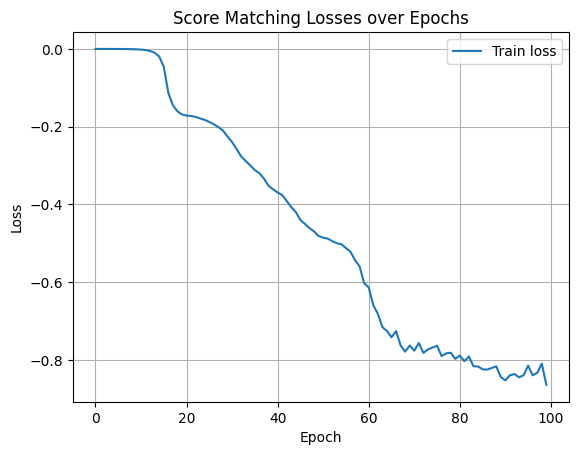

In [508]:
plt.plot(train_losses, label="Train loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Score Matching Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\79217\AppData\Local\Temp\ipykernel_7008\862432006.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intensity_pred = model(torch.tensor(x_lin[:, None], dtype=torch.float32)).squeeze().detach().numpy()


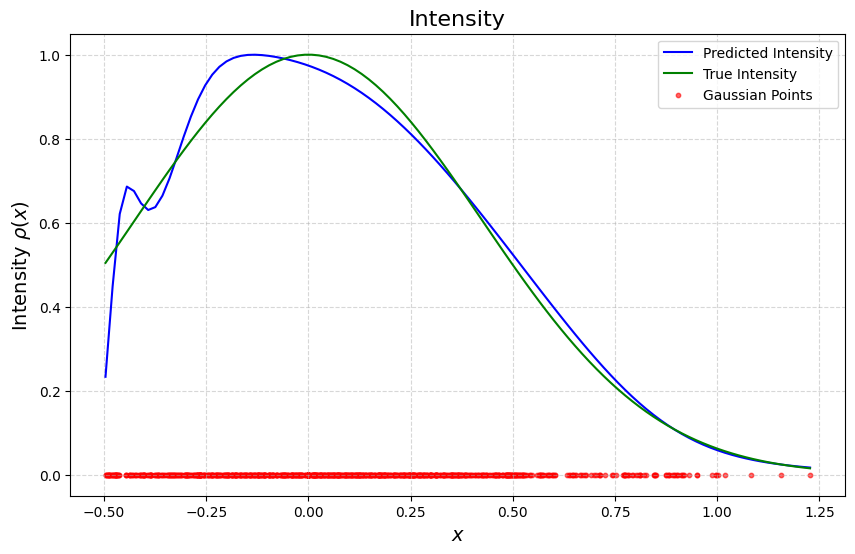

In [509]:
# Extract the 1D data
x = X_test[1][:, 0]

# Compute range for the 1D data
x_min, x_max = x.min(), x.max()

# Generate a 1D grid for intensity
x_lin = np.linspace(x_min, x_max, 100)  # Adjust resolution if needed

# Compute predicted intensity values for the grid
intensity_pred = model(torch.tensor(x_lin[:, None], dtype=torch.float32)).squeeze().detach().numpy()

# Compute true intensity values for the grid (assuming Gaussian distribution)
intensity_real = kappa * torch.exp(-x_lin[:, None]**2 / scale**2)

# Plot 1: Predicted Intensity Function
plt.figure(figsize=(10, 6))
plt.plot(x_lin, intensity_pred / np.max(intensity_pred), label='Predicted Intensity', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plot 2: True Intensity Function
plt.plot(x_lin, intensity_real / intensity_real.max(), label='True Intensity', color='green')
plt.scatter(x, np.zeros_like(x), c='red', s=10, alpha=0.6, label='Gaussian Points')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.title('Intensity', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [510]:
x = X_test[0][:, 0].numpy()
y = X_test[0][:, 1].numpy()
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
intensity_pred = model(torch.tensor(grid_points, dtype=torch.float32)).detach().numpy()
intensity_pred_2d = intensity_pred.reshape(xx.shape)
    
intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Model-predicted intensity
c1 = axs[0].contourf(
    xx, yy, intensity_pred_2d, levels=50,
    cmap='viridis', alpha=0.8, # vmin=0, vmax=1
)
axs[0].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
axs[0].set_title(r'Predicted Intensity $\rho(x)$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=14)
axs[0].set_ylabel(r'$y$', fontsize=14)
axs[0].legend()
axs[0].set_aspect('equal')
axs[0].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c1, ax=axs[0], label="Normalized Intensity")

# Plot 2: True intensity
if isinstance(intensity_real, torch.Tensor):
    intensity_real = intensity_real.numpy()
c2 = axs[1].contourf(
    xx, yy, intensity_real, levels=50,
    cmap='viridis', alpha=0.7, # vmin=0, vmax=1
)
axs[1].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
axs[1].set_title('True Intensity', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=14)
axs[1].set_ylabel(r'$y$', fontsize=14)
axs[1].legend()
axs[1].set_aspect('equal')
axs[1].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c2, ax=axs[1], label="Normalized Intensity")

plt.tight_layout()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x2 and 1x64)

In [8]:
def calculate_score_matching_difference(intensity_real, intensity_pred):
    """
    Calculate the Score Matching Difference (SMD) between the real and predicted intensities.

    Parameters:
    - intensity_real: Flattened array of real intensity values.
    - intensity_pred: Flattened array of predicted intensity values.

    Returns:
    - float: Score Matching Difference.
    """
    # Ensure inputs are numpy arrays
    intensity_real = np.asarray(intensity_real)
    intensity_pred = np.asarray(intensity_pred)
    
    # Compute the gradient of the log intensities
    gradient_real = np.gradient(np.log(intensity_real))
    gradient_pred = np.gradient(np.log(intensity_pred))
   
    return np.sum((gradient_real - gradient_pred) ** 2)

In [512]:
smd = calculate_score_matching_difference(intensity_real.ravel(), intensity_pred.ravel())
smd

np.float32(0.6190822)

In [513]:
mse_list = []
r2_list = []

# Iterate over the test loader
for batch in loader_test:
    for x_test in batch[0]:
        x_test = x_test[:, 0]

        intensity_real = kappa * torch.exp(-x_test[:, None]**2 / scale**2)
        intensity_real = np.asarray(intensity_real)

        # Predict intensities using the model
        intensity_pred = model(x_test[:, None]).squeeze().detach().numpy()

        # Normalize predicted and true intensities for consistency
        intensity_pred /= np.max(intensity_pred)
        intensity_real /= np.max(intensity_real)

        # Compute MSE and R-squared for this batch
        mse = mean_squared_error(intensity_real, intensity_pred)
        r2 = r2_score(intensity_real, intensity_pred)

        # Append metrics to the list
        mse_list.append(mse)
        r2_list.append(r2)

# Compute average MSE and R-squared over all test samples
average_mse = np.mean(mse_list)
average_r2 = np.mean(r2_list)

print(f"Average MSE across all test samples: {average_mse}")
print(f"Average R-squared across all test samples: {average_r2}")

Average MSE across all test samples: 0.0022092469152994454
Average R-squared across all test samples: 0.9609979540109634


In [317]:
mse_list = []
r2_list = []

# Iterate over the test loader
for batch in loader_test:
    # Assume `batch` contains the test input data
    x_test = batch[0]

    # Generate true intensity values (assuming Gaussian distribution as before)
    x_min, x_max = x_test.min().item(), x_test.max().item()
    x_lin = np.linspace(x_min, x_max, 100)
    intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)

    # Predict intensities using the model
    intensity_pred = (
        model(torch.tensor(x_lin[:, None], dtype=torch.float32)).squeeze().detach().numpy()
    )

    # Normalize predicted and true intensities for consistency
    intensity_pred /= np.max(intensity_pred)
    intensity_real /= np.max(intensity_real)

    # Compute MSE and R-squared for this batch
    mse = mean_squared_error(intensity_real, intensity_pred)
    r2 = r2_score(intensity_real, intensity_pred)

    # Append metrics to the list
    mse_list.append(mse)
    r2_list.append(r2)

# Compute average MSE and R-squared over all test samples
average_mse = np.mean(mse_list)
average_r2 = np.mean(r2_list)

print(f"Average MSE across all test samples: {average_mse}")
print(f"Average R-squared across all test samples: {average_r2}")

C:\Users\79217\AppData\Local\Temp\ipykernel_7008\1079215482.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1 and 2x32)

In [19]:
num_experiments = 10
mse_results = []
r2_results = []
smd_results = []

num_samples = 100
train_ratio = 0.8
batch_size = 32

kappa = torch.tensor(1000.0)
scale = torch.tensor(0.6)

region = (-0.5, 3)

epochs = 100
learning_rate = 1e-5

weighting = True

output_file = f"outputs/poisson_weighted_results_weighting_{weighting}_num_samples_{num_samples}.txt"


with open(output_file, "w") as f:
    f.write(f"Poisson NN Score Matching Experiment Results\n")
    f.write(f"Number of Experiments: {num_experiments}\n")
    f.write(f"Number of Samples per Experiment: {num_samples}\n")
    f.write(f"Train Ratio: {train_ratio}\n")
    f.write(f"Batch Size: {batch_size}\n\n")
    f.write(f"Weighting: {weighting}\n\n")
    for exp in range(num_experiments):
        print(f"Running Experiment {exp + 1}/{num_experiments}...")

        # Generate new Poisson process samples
        samples = [torch.tensor(generate_poisson_points_1d(kappa, scale, region)).unsqueeze(-1) for _ in range(num_samples)]
        samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

        # Prepare training and test data
        X = pad_sequence(samples_torch, batch_first=True, padding_value=0)
        lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

        m = len(X)
        train_size = int(train_ratio * m)

        X_train = X[:train_size]
        X_test = X[train_size:]

        loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
        loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

        # Train model
        model, train_losses = optimize_nn(
            loader_train, Poisson_NN, num_epochs=epochs, learning_rate=learning_rate, weighting=weighting
        )

        mse_list = []
        r2_list = []

        # Iterate over the test loader
        for batch in loader_test:
            for x_test in batch[0]:
                x_test = x_test[:, 0]

                intensity_real = kappa * torch.exp(-x_test[:, None]**2 / scale**2)
                intensity_real = np.asarray(intensity_real)

                # Predict intensities using the model
                intensity_pred = model(x_test[:, None]).squeeze().detach().numpy()

                # Normalize predicted and true intensities for consistency
                intensity_pred /= np.max(intensity_pred)
                intensity_real /= np.max(intensity_real)

                # Compute MSE and R²
                mse = mean_squared_error(intensity_real, intensity_pred)
                r2 = r2_score(intensity_real, intensity_pred)

                mse_list.append(mse)
                r2_list.append(r2)

        # Compute average MSE and R² for this experiment
        avg_mse = np.mean(mse_list)
        avg_r2 = np.mean(r2_list)

        # Compute SMD
        smd = calculate_score_matching_difference(intensity_real.ravel(), intensity_pred.ravel())

        # Store results
        mse_results.append(avg_mse)
        r2_results.append(avg_r2)
        smd_results.append(smd)

        print(f"Experiment {exp + 1} - MSE: {avg_mse:.6f}, R²: {avg_r2:.6f}, SMD: {smd:.6f}")

    # Compute final average metrics across all experiments
    final_mse = np.mean(mse_results)
    final_r2 = np.mean(r2_results)
    final_smd = np.mean(smd_results)
    
    f.write("\nFinal Results:\n")
    f.write(f"Mean MSE: {final_mse:.6f}\n")
    f.write(f"Mean R²: {final_r2:.6f}\n")
    f.write(f"Mean SMD: {final_smd:.6f}\n")

print("\nFinal Results:")
print(f"Mean MSE: {final_mse:.6f}")
print(f"Mean R²: {final_r2:.6f}")
print(f"Mean SMD: {final_smd:.6f}")

Running Experiment 1/10...


Training: 100%|██████████| 100/100 [00:33<00:00,  2.98epoch/s, Train Loss=-0.1133, Time/Epoch=0.30s]


Experiment 1 - MSE: 0.005299, R²: 0.907735, SMD: 8.983774
Running Experiment 2/10...


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95epoch/s, Train Loss=-0.1646, Time/Epoch=0.31s]


Experiment 2 - MSE: 0.000993, R²: 0.982695, SMD: 4.593984
Running Experiment 3/10...


Training: 100%|██████████| 100/100 [00:32<00:00,  3.12epoch/s, Train Loss=-0.1704, Time/Epoch=0.28s]


Experiment 3 - MSE: 0.002274, R²: 0.960799, SMD: 12.097582
Running Experiment 4/10...


Training: 100%|██████████| 100/100 [00:30<00:00,  3.29epoch/s, Train Loss=-0.0888, Time/Epoch=0.32s]


Experiment 4 - MSE: 0.001373, R²: 0.976366, SMD: 5.923084
Running Experiment 5/10...


Training: 100%|██████████| 100/100 [00:28<00:00,  3.46epoch/s, Train Loss=-0.1404, Time/Epoch=0.27s]


Experiment 5 - MSE: 0.001009, R²: 0.982037, SMD: 3.790532
Running Experiment 6/10...


Training: 100%|██████████| 100/100 [00:29<00:00,  3.35epoch/s, Train Loss=-0.2097, Time/Epoch=0.28s]


Experiment 6 - MSE: 0.001531, R²: 0.973519, SMD: 2.835830
Running Experiment 7/10...


Training: 100%|██████████| 100/100 [00:28<00:00,  3.53epoch/s, Train Loss=-0.1866, Time/Epoch=0.30s]


Experiment 7 - MSE: 0.003650, R²: 0.935495, SMD: 9.150920
Running Experiment 8/10...


Training: 100%|██████████| 100/100 [00:32<00:00,  3.04epoch/s, Train Loss=-0.1809, Time/Epoch=0.40s]


Experiment 8 - MSE: 0.002910, R²: 0.948471, SMD: 9.504181
Running Experiment 9/10...


Training: 100%|██████████| 100/100 [00:30<00:00,  3.28epoch/s, Train Loss=-0.1324, Time/Epoch=0.30s]


Experiment 9 - MSE: 0.001288, R²: 0.977635, SMD: 7.157164
Running Experiment 10/10...


Training: 100%|██████████| 100/100 [00:29<00:00,  3.35epoch/s, Train Loss=-0.0756, Time/Epoch=0.29s]

Experiment 10 - MSE: 0.001500, R²: 0.973146, SMD: 5.946033

Final Results:
Mean MSE: 0.002183
Mean R²: 0.961790
Mean SMD: 6.998308
